# **Predicting Titanic Survivability with Random Forests**

In [80]:
from fastai.imports import *            # Imports all the necessary libraries for ML like pandas, numpy, etc.

## **Data Preprocessing**

Random Forests require significantly less data preprocessing (inc. cleaning) which is why Random Forests are easy to implement and hard to mess up.

In [81]:
path = Path('titanic')
df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [82]:
modes = df.mode().iloc[0]       # Calculates the mode of each column and stores it in modes
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

We don't have to create dummy variables like we did in linear regression.

Instead, we can convert these fields to categorical variables. Internally, pandas replaces each unique value with a specific number, which acts as the index for looking up the values in the list of unique values.

In [83]:
# Creating a function for data preprocessing
def proc_data(df):
    # Not necessary to calculate the LogFare, we do it to make the graph more 'distributed
    df['Fare'] = df.Fare.fillna(0)          # Replacing NA values in Fare with 0
    df.fillna(modes, inplace=True)          # Replacing other NA values with their modes
    df['LogFare'] = np.log1p(df['Fare'])    # .log1p() calculates the log of Fare + 1
    df['Embarked'] = pd.Categorical(df.Embarked)    # Converting Embarked into a categorical variable
    df['Sex'] = pd.Categorical(df.Sex)
    
# Preprocessing training and testing data
proc_data(df)
proc_data(test_df)  

We treat `Pclass` as an ordered variable instead of a categorical variable here. As 1st class is better than 2nd, 2nd class is better than 3rd, and so on. So internally, the `Pclass` value won't be treated as independent values but ordered values.

In decision trees, order matter a lot. They care only about order and not the mean absolute value.

We divide the list of columns into Categorical, Dependent and Continuous.

Continuous variables are variables which can accept any value in a given range.

In [84]:
cats = ['Sex', 'Embarked']                                  # Categorical variables
conts = ['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']      # Continuous variables
dep = 'Survived'                                            # Dependent variable

While categorical values show their actual values (e.g. S, C, Q), internally they are stored as numbers which act as indexes.

In [85]:
df.Embarked.head()             

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: category
Categories (3, object): ['C', 'Q', 'S']

In [86]:
# Checking the integers associated with different values in Embarked
df.Embarked.cat.codes.head()            # 2 -> S, 0 -> C, 1 -> Q

0    2
1    0
2    2
3    2
4    2
dtype: int8

## **Binary Splits**

Random Forests are built on decision trees, and to create a decision tree, we need to create a binary split

A binary split segregates the rows into 1 of 2 groups based on whether they're above or below a certain threshold.

E.g. We can split the rows into Male and Female by using the threshold 0.5 for the `Sex` column (0 corresponds to Female and 1 to Male). Let's see how that would split up our data

[Text(0.5, 1.0, 'Histogram')]

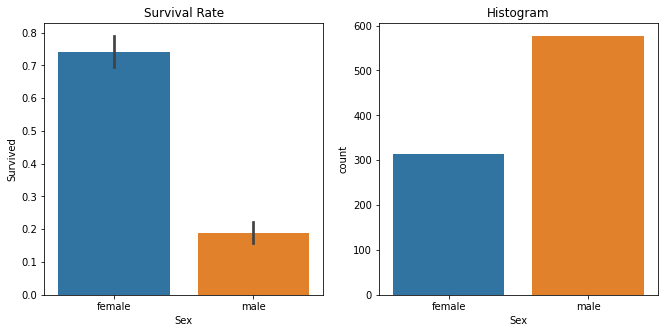

In [87]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(11, 5))      # Creates a figure  1 row and 2 columns (2 plots) of width 11 and height 5 inches
# fig stores the figure and axs holds

sns.barplot(data=df, x='Sex', y=dep, ax=axs[0]).set(title="Survival Rate")              # axs[0] refers to the 1st plot

sns.countplot(data=df, x='Sex', ax=axs[1]).set(title="Histogram")

# Barplot displays the mean of a variable while countplot displays the total count

Some observations:
- Survival rate is > 0.7 (70%) for females while < 0.2 (20%) for males
- There are around 300 female passengers as compared to close to 600 male passengers

Data suggests that females are significantly more likely to survive than males. We can create a very basic model that predicts that all females survive and no males do.

In [88]:
# Splitting data into training and validation set
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.2)
 
# Replacing category variable values with their corresponding integer values (necessary for binary split)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)        
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [89]:
# Creating a function to define the dependent (xs - multiple dependent variables) and independent variables (y)
def xs_y(df):
    xs = df[cats+conts].copy()      # Dependent variables include all categorical and continuous variables
    y = df[dep]
    return xs, y

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

Calculating the predictions for our basic model (where Female=0)

In [90]:
preds = val_xs.Sex == 0

Using mean absolute error to see how good our model is

In [91]:
from sklearn.metrics import mean_absolute_error
f"{mean_absolute_error(val_y, preds):.3f}"          # Rounding off to 3 decimal places

'0.218'

Let's try splitting a regular column: `LogFare` and compare the results.

<AxesSubplot: xlabel='LogFare', ylabel='Density'>

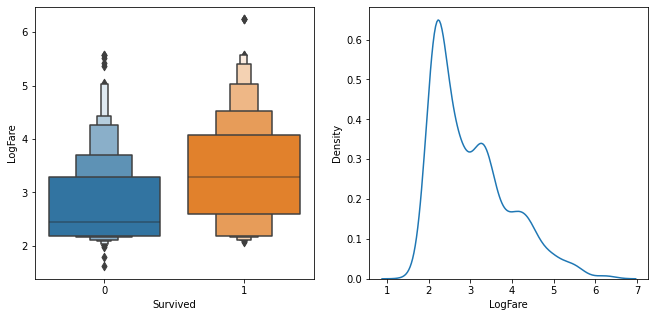

In [92]:
df_fare = trn_df[trn_df.LogFare>0]              # Ensuring only valid fares are stored (in case there are some anomalies in the data)
fig, axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y='LogFare', ax=axs[0])        # boxenplot is an enhanced version of boxplot
sns.kdeplot(data=df_fare, x='LogFare', ax=axs[1])       # kdeplot is a kernel distribution plot

# kdeplot is used to visualize the distribution of observations. It's like a histogram but it smoothens the data, making it easier to observe the shape and recognize any outliers

The horizontal line going across the box indicates the average `LogFare` for a particular condition.

Some observations:
- The average `LogFare` for a passenger that died is around 2.5
- The average `LogFare` for a passenger that survived is around 3.25
- It implies that people who bought more expensive tickets were more likely to survive

We can create a model based on this observation

In [93]:
preds = val_xs.LogFare > 2.5

In [94]:
f"{mean_absolute_error(val_y, preds):.3f}"

'0.341'

As the mean absolute error is higher, this model is less accurate than the model that used `Sex`.

We can try out different splits and compare the performance by creating a `score` function.

In the `score` function, we will not be returning the mean absolute error, we will return the *impurity*. When 2 groups are created after binary splitting, impurity tells us how similar or dissimilar rows in the same group are to each other.

We can measure the similarity of a group by calculating it's standard deviation of the dependent variable. Then, we multiply the standard deviation by the number of rows (as more rows have a bigger impact than a smaller number of rows).

A higher standard deviation indicates that the rows are different to each other, while a low standard deviation indicates that the rows are similar. Groups with lower standard deviation are likely to be more predictive as the data is similar.

In [95]:
# Function to calculate the score of 1 side of the binary split

def _side_score(side, y):
    tot = side.sum()            # Finding the total number of rows in one side of the binary split
    if tot<=1:
        return 0                # If there are 0 or just 1 rows in one side of the binary split, we return 0, as the data is too small to calculate the score
    side_score = y[side].std()*tot      # Calculating the score, .std() calculates the standard deviation
    return side_score

In [96]:
# Function to calculate the score of the entire binary split by adding up LHS and RHS side scores

def score(col, y, split):
    lhs = col<=split            # lhs = columns on the LHS of the split value
    rhs = col>split             # rhs = columns on the RHS of the split value
    score = (_side_score(lhs, y) + _side_score(rhs, y))/len(y)      # We divide by the total number of rows to normalize the score
    return score

In [97]:
# Checking the impurity of the 'Sex' column
score(trn_xs['Sex'], trn_y, 0.5)        # Split is at 0.5 as 0 indicates Female and 1 indicates Male

0.4071185316952624

In [98]:
# Checking the impurity of the 'LogFare' column
score(trn_xs["LogFare"], trn_y, 2.5)            # 2.5 as average LogFare of passenger who died is 2.5

0.4651064148690222

We again come to our previous conclusion, splitting on `Sex` is a better idea than splitting on `LogFare` as the score of `LogFare` column is higher than the score of `Sex` column.

Reminder: we aim for a lower score, not a higher one!

Automatically calculating the best split for a particular column...

In [99]:
col = trn_xs['Age']
unq = col.unique()          # Finding all the unique values for a column
unq.sort()

In [100]:
scores = np.array([])
for o in unq:
    if not np.isnan(o):
        scores = np.append(scores, score(col, trn_y, o))  # Calculating the score for each split which is not NaN

# Finding the unique value for the lowest score
unq[np.argmin(scores)]  # np.argmin() returns the index position of the minimum score

5.0

Looks like 5 is the ideal split for the `Age` column.

We can write a function that automatically calculates the ideal split for a column

In [101]:
def min_col(df, nm):
    col, y = df[nm], df[dep]
    unq = col.dropna().unique()         # Dropping all the NA values
    
    scores=np.array([])
    for o in unq:
        scores = np.append(scores, score(col, y, o))
        
    idx = scores.argmin()               # index value of the minimum score
    return unq[idx], scores[idx]        # Returning the column value for ideal split and the corresponding score

In [102]:
# Let's calculate it for Age
min_col(trn_df, "Age")

(5.0, 0.47912809551390306)

Ideal split is for `Age` column is 5 and the corresponding minimum score is 0.479.

Now let's try it for all the columns!

In [103]:
cols = cats + conts     # Categorical + Continuous variables form all the independent variables

result = {}             # A dictionary to store the results. Key = column name and value = column index for min. score and the corresponding min. score
for o in cols:
    result[o] = min_col(trn_df, o)
    
result

{'Sex': (0, 0.4071185316952624),
 'Embarked': (0, 0.47886783284983037),
 'Age': (5.0, 0.47912809551390306),
 'SibSp': (4, 0.47823318504095064),
 'Parch': (0, 0.48025779612275027),
 'LogFare': (2.4390808375825834, 0.46224531743487196),
 'Pclass': (2, 0.4592920418332917)}

Some observations:
- Splitting `Sex` at 0 is our best binary split
- Splitting `Parch` at 0 is the worst binary split (out of the best binary split for each column)
- So `Parch` can be considered the least important column while `Sex` is the most important column.

## **Creating a Decision Tree**

How can we improve our model?

We can take each of the split: Male and Female, and create one more split for them.
Finding the single best split for Female and the single best split for Male and split the 2 groups accordingly.

In [104]:
cols.remove("Sex")              # Removing Sex column from possible splits as we've already used it
ismale = trn_df.Sex==1          # Passenger is male if Sex = 1
males, females = trn_df[ismale], trn_df[~ismale]        # ~ is used for flipping binary values, so ~ismale indicates all rows that are not male

Finding the best split for males

In [105]:
male_split = {}
for o in cols:
    male_split[o] = min_col(males, o)
    
male_split

{'Embarked': (0, 0.38576043379210306),
 'Age': (6.0, 0.3737698830682865),
 'SibSp': (4, 0.38564510164760585),
 'Parch': (0, 0.38587758360944274),
 'LogFare': (3.305053521109253, 0.37847540613258673),
 'Pclass': (1, 0.3791346684984454)}

Splitting at `Age` column where Age = 6 is the single best split for the `Male` group

In [106]:
female_split = {}
for o in cols:
    female_split[o] = min_col(females, o)
    
female_split

{'Embarked': (0, 0.43058267603439193),
 'Age': (50.0, 0.4241471429934961),
 'SibSp': (2, 0.42349263420023586),
 'Parch': (3, 0.4226743361917132),
 'LogFare': (3.8691155044168695, 0.41363647863043046),
 'Pclass': (2, 0.33807632780952696)}

Splitting `Pclass` column where Pclass = 2 is the single best split for the `Female` group

We can create a simple decision tree by adding these rules.

The model will first split at `Sex` depending whether Sex is Male or Female. If Male, the tree will further split at `Age` depending on whether Age <= 6 or not. If Female, the tree will further split at `Pclass` depending on whether Pclass <= 2 or not.

The process of creating a decision tree can be automated using `DecisionTreeClassifier`.

In [107]:
from sklearn.tree import DecisionTreeClassifier

# Creating a decision tree with max leaf nodes (max possible endpoints after the final split) as 4 and training it on our training data
m =  DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y)

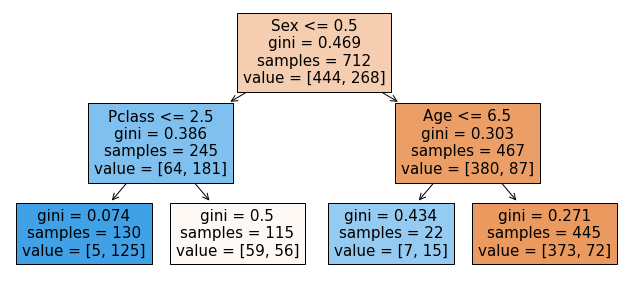

In [108]:
from sklearn.tree import plot_tree

plt.figure(figsize=(11, 5))
plot_tree(m, filled=True, feature_names=trn_xs.columns)  # Plotting a tree to visualize the splits
plt.show()

The more orange a box is, the lower the survival rate. The more blue a box is, the higher the survival rate. LHS indicates True (condition met) and RHS indicates False (condition not met).

The classifier splits on the same columns as the ones we came up with.

To measure the impurity of a split, we use **gini**, it is quite similar to the `score()` function we devised.

gini calculates the probability that if you pick 2 rows from the same group of a split, you'll get the same `Survived` (dependent variable) result each time.

In [109]:
def gini(cond):
    act = df.loc[cond, dep]             # act contains Survived's value for the rows which matches the condition
    
    # gini is calculated by the formula 1 - p^2 - ((1-p)^2) where p is the proportion of positive instances (Survived=1 here)
    gini_val = 1 - act.mean()**2 - (1-act).mean()**2
    return gini_val

In [110]:
gini(df.Sex=='female'), gini(df.Sex=='male')        # Calculating the gini values for Male and Female splits

(0.3828350034484158, 0.3064437162277842)

Let's see how our model with more nodes compares to our initial model (of splitting only on `Sex`)

In [111]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2346368715083799

Our model with more leaf nodes performs slightly worse than our initial model, but the difference is so small that it's insignificant for our small sized dataset (of about 200 rows in validation set).

Let's try increasing the number of leaf nodes

In [112]:
m = DecisionTreeClassifier(min_samples_leaf=50)         # stops splitting after the leaf contains < 50 samples
m.fit(trn_xs, trn_y)

DecisionTreeClassifier(min_samples_leaf=50)

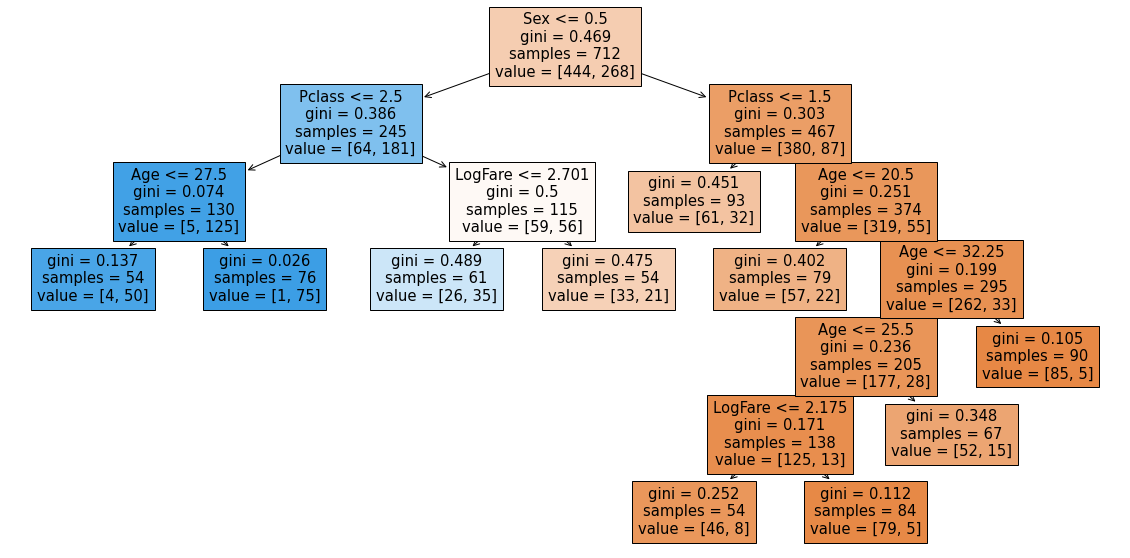

In [113]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(m, filled=True, feature_names=trn_xs.columns)
plt.show()


In [114]:
# Calculating the mean absolute error for this model
mean_absolute_error(val_y, m.predict(val_xs))

0.18994413407821228

This model performs significantly better than our previous 2 models! But as the dataset is small, we cannot really rely completely on the conclusion (Decision Trees are better suited for larger datasets).

## **Random Forests (Finally)**

We cannot make our decision trees much bigger as the leaf nodes have fewer than 50 rows of data to work with, which isn't a lot of data. So how do we improve the accuracy further?

What we can do is that we can create a lot of big trees and find out the average of the predictions of each model. This process of taking an average prediction of a bunch of models  is known as **bagging**.

The idea is that we want each model's predictions in the averaged ensemble (averaged sum of models) to be uncorrelated to other models. Meaning that each model's errors are not correlated to the errors of other models.

As the sum of a large number of uncorrelated random errors is 0, if we average the predictions, the average will be equal to the true target (dependent variable) value.

One way to create a bunch of unrelated models is to train each of them on a random subset of data.

In [115]:
# Training a model on a random subset of data
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))        # Randomly chooses a subset of data, n is the upper limit, n*props gives the total number of rows to select
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [116]:
# Creating 100 trees
trees = []
for t in range(100):
    tr = get_tree()
    trees.append(tr)

Our prediction = average of the trees' predictions

In [117]:
# Calculating the average of the predictions
all_probs = []

for t in trees:
    all_probs.append(t.predict(val_xs))  

avg_probs = np.stack(all_probs).mean(0)         # Stacking all the predictions into a NumPy array and calculating the mean across axis 0

mean_absolute_error(val_y, avg_probs)           # Seeing how good our model is

0.21793296089385478

Let's do the same using sklearn's `RandomForestClassifier`. The key difference is that while it chooses a random subset of rows like we do in our model, it also picks a random subset of columns.

In [118]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)            # Making 100 decision trees with at least 5 simples in each leaf node
rf.fit(trn_xs, trn_y)
mean_absolute_error(val_y, rf.predict(val_xs))

0.18435754189944134

This is our best performing model as it has the lowest mean absolute error! But the mean absolute error is very close to the mean absolute error of the single decision tree we created.

My Conclusion? More complex models are not always better, especially when data is limited (though Random Forests are great models to use when we have a decent amount of data).

We can also analyze the importance of each independent variable in a Random Forest

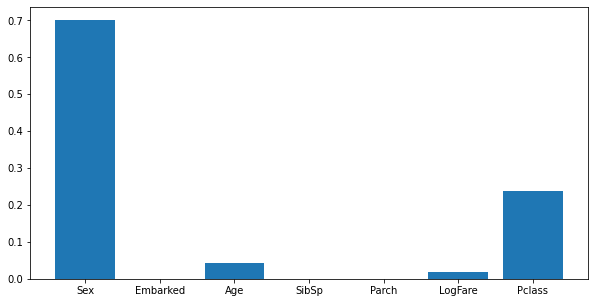

In [119]:
data = {'cols': trn_xs.columns, 'imp': m.feature_importances_}
df = pd.DataFrame(data)
plt.figure(figsize=(10, 5))
plt.bar(df['cols'], df['imp'])          # Creating a bar plot
plt.show()

Again we come to the conclusion that `Sex` was the most import parameter, followed by `PClass`. 